In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

%matplotlib inline

sns.set()

dick = pd.read_pickle('country_data.pkl')

limit = 100 # min nr of confirmed

  

In [206]:
country_density = pd.read_csv('world_density.csv',sep=';',usecols=['name','area','pop2020'])
country_density['density'] = country_density['pop2020'] / country_density['area']
country_density.set_index('name',inplace=True)
country_density['pop2020'] *= 1000
country_density['density'] *= 1000
country_density

,pop2020,area,density
name,,,
Macau,649335.0,30.00,21644.500000
Monaco,39242.0,2.02,19426.732673
Singapore,5850342.0,710.00,8239.918310
Hong Kong,7496981.0,1104.00,6790.743659
Gibraltar,33691.0,6.00,5615.166667
...,...,...,...
Namibia,2540905.0,825615.00,3.077591
Western Sahara,597339.0,266000.00,2.245635
Mongolia,3278290.0,1564110.00,2.095946


In [207]:
def remove_dollar(s):
    return s[1:].replace(',','')

country_gdp = pd.read_csv('world_gdp.csv',sep=';',
                          usecols=[1,2,6],thousands=',',header=None,
                         converters={2:remove_dollar,6:remove_dollar})

country_gdp.columns = ['name','gdp','gdp_per_capita']
country_gdp.set_index('name',inplace=True)
country_gdp['gdp'] = country_gdp['gdp'].astype(int)
country_gdp['gdp_per_capita'] = country_gdp['gdp_per_capita'].astype(int)

country_gdp.loc['US']

gdp               19485394000000
gdp_per_capita             59939
Name: US, dtype: int64

In [208]:
print (country_gdp.sort_values('gdp_per_capita',ascending=False).head(10))
print (country_gdp.sort_values('gdp_per_capita',ascending=False).tail(10))

                          gdp  gdp_per_capita
name                                         
Luxembourg        62316359824          105280
Macao             50361201096           80890
Switzerland      678965423322           80296
Norway           399488897844           75428
Iceland           24488467010           73233
Ireland          331430014003           69727
Qatar            166928571429           61264
US             19485394000000           59939
United States  19485394000000           59939
Denmark          329865537183           57545
                                  gdp  gdp_per_capita
name                                                 
Togo                       4757776485             618
Afghanistan               19543976895             538
Sierra Leone               3775047334             504
DR Congo                  37642482562             462
Madagascar                11499803807             450
Mozambique                12645508634             441
Central African 

In [209]:
def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


good_countries = []

def add_population_data(country_name,limit):
    
    all_good = True
    
    df = dick[country_name]
    try:
        df['conf_per_M'] = df['confirmed'] / (country_populations.loc[country_name,'population'] / 1e6)
        df['dead_per_M'] = df['deceased'] / (country_populations.loc[country_name,'population'] / 1e6)
        df['population'] = country_populations.loc[country_name,'population']
    except:
        all_good = False
        print ('\tcant find population data for {}'.format(country_name))
    try:
        df['density'] = country_density.loc[country_name,'density']
    except:
        all_good = False
        print ('\tcant find density for {}'.format(country_name))
        
    try:
        df['gdp'] = country_gdp.loc[country_name,'gdp']
        df['gdp_per_capita'] = country_gdp.loc[country_name,'gdp_per_capita']
    except:
        all_good = False
        print ('cant find gdp for {}'.format(country_name))
        
    if all_good:
        good_countries.append(country_name)
        
    df.drop(['conf_over_dead','dead_conf_ratio'],axis=1,inplace=True)
    
    df.replace(np.inf,np.nan,inplace=True)

    df = df[df['confirmed'] > limit]
    
    return df

for c in list(dick.keys()):
    dick[c] = add_population_data(c,limit)
    

	cant find population data for Bahamas
	cant find density for Cabo Verde
	cant find population data for Congo (Brazzaville)
	cant find density for Congo (Brazzaville)
cant find gdp for Congo (Brazzaville)
	cant find population data for Congo (Kinshasa)
	cant find density for Congo (Kinshasa)
cant find gdp for Congo (Kinshasa)
	cant find population data for Cote d'Ivoire
	cant find density for Cote d'Ivoire
cant find gdp for Cote d'Ivoire
	cant find population data for Diamond Princess
	cant find density for Diamond Princess
cant find gdp for Diamond Princess
cant find gdp for Djibouti
cant find gdp for Eritrea
	cant find density for Eswatini
	cant find density for Holy See
cant find gdp for Holy See
cant find gdp for Liechtenstein
cant find gdp for Monaco
	cant find density for North Macedonia
	cant find population data for Saint Vincent and the Grenadines
cant find gdp for Saint Vincent and the Grenadines
cant find gdp for Somalia
cant find gdp for Taiwan*
cant find gdp for Venezuela


In [210]:
swe = dick['Sweden']
print (swe.tail())
us = dick['US']
print (us.tail())

            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-04-08       8419  1.094372  726.0       687     1.162437      96.0   
2020-04-09       9141  1.085758  722.0       793     1.154294     106.0   
2020-04-10       9685  1.059512  544.0       870     1.097100      77.0   
2020-04-11      10151  1.048116  466.0       887     1.019540      17.0   
2020-04-12      10483  1.032706  332.0       899     1.013529      12.0   

            pct_dead   conf_per_M  dead_per_M  population    density  \
2020-04-08  8.160114   833.625021   68.024752    10099265  22.428108   
2020-04-09  8.675200   905.115372   78.520566    10099265  22.428108   
2020-04-10  8.982963   958.980678   86.144883    10099265  22.428108   
2020-04-11  8.738055  1005.122650   87.828174    10099265  22.428108   
2020-04-12  8.575789  1037.996329   89.016379    10099265  22.428108   

                     gdp  gdp_per_capita  
2020-04-08  535607385506           54075  
2020-04-09  535607385506      

In [211]:
#### PARAM
####
multiple_regression = False
y_param = 'conf_per_M'
#x1_param = 'gdp_per_capita'
x2_param = 'density'

x1_param = 'density'

outliers = 3


####
####

def standardize(n):
    return (n - n.mean()) / n.std()

def process_countries(countries):
    nr_of_fails = 0
    
    x1_list = []
    x2_list = []
    y_list = []
    
    for country_name in countries:
        
        try:
        
            df = dick[country_name]
            y = df[y_param][-1]
            x1 = df[x1_param][-1]
            x2 = df[x2_param][-1] 
        
            x1_list.append(x1)
            x2_list.append(x2)
            y_list.append(y)
        
        except:
            print ('cant get data for {}'.format(country_name) )
            nr_of_fails += 1
            good_countries.remove(country_name)
            
    x1 = np.array(x1_list)
    x2 = np.array(x2_list)
    y = np.array(y_list)
    
    x1_std = standardize(x1)
    x2_std = standardize(x2)
    y_std = standardize(y)
    
    
    x1_outliers =  (x1_std > outliers) | (x1_std < -1 * outliers) #std
    x2_outliers = (x2_std > outliers) |  (x1_std < -1 * outliers) #std
    y_outliers = (y_std > outliers) | (x1_std < -1 * outliers) #std
    
    outlier_idx = (x1_outliers | x2_outliers | y_outliers)
    
    x1 = x1[~outlier_idx]
    x1_std = x1_std[~outlier_idx]
    x2 = x2[~outlier_idx]
    x2_std = x2_std[~outlier_idx]
    y = y[~outlier_idx]
    y_std = y_std[~outlier_idx]
    
    x1_mu = x1.mean()
    x1_sigma = x1.std()
    x2_mu = x2.mean()
    x2_sigma = x2.std()
    y_mu = y.mean()
    y_sigma = y.std()
    
    print ('correlation:')
    print (np.corrcoef(x1_std,y_std))
    
    return x1_std,x2_std,y_std,x1_mu,x1_sigma,x2_mu,x2_sigma,y_mu,y_sigma,nr_of_fails
    
    
#countries = ['Sweden','Finland','Norway','Denmark','Iceland']

countries = good_countries

x1,x2,y,x1_mu,x1_sigma,x2_mu,x2_sigma,y_mu,y_sigma,nr_of_fails = process_countries(countries)
nr_of_successful_countries = len(countries) 

for c in countries:
    print (c)

cant get data for Angola
cant get data for Barbados
cant get data for Benin
cant get data for Central African Republic
cant get data for Equatorial Guinea
cant get data for Ethiopia
cant get data for Gabon
cant get data for Guyana
cant get data for Jamaica
cant get data for Liberia
cant get data for Maldives
cant get data for Mauritania
cant get data for Mongolia
cant get data for Namibia
cant get data for Nicaragua
cant get data for Papua New Guinea
cant get data for Saint Lucia
cant get data for Seychelles
cant get data for Sudan
cant get data for Tanzania
cant get data for Togo
cant get data for Uganda
cant get data for Zambia
cant get data for Dominica
cant get data for Mozambique
cant get data for Belize
cant get data for Libya
cant get data for Botswana
cant get data for Sierra Leone
cant get data for Yemen
correlation:
[[1.         0.13967431]
 [0.13967431 1.        ]]
Afghanistan
Albania
Algeria
Andorra
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain


In [212]:

def regression(x1,x2,y):
    
    beta1_mu = pm.Uniform('beta1_mu',-1,1)
    beta1_sigma = pm.Uniform('beta1_sigma',0,1)
    
    beta2_mu = pm.Uniform('beta2_mu',-1,1)
    beta2_sigma = pm.Uniform('beta2_sigma',0,1)
    
    obs_sigma = pm.Uniform('obs_sigma',0,5)
    
    alpha = pm.Uniform('alpha',-1,1)
    
    beta1 = pm.Normal('beta1',beta1_mu, 1 / beta1_sigma ** 2)
    beta2 = pm.Normal('beta2',beta2_mu, 1 / beta2_sigma ** 2)

    if multiple_regression:
        @pm.deterministic()
        def linreq(x1=x1,x2=x2,beta1=beta1,beta2=beta2,alpha=alpha):
            return x1 * beta1 + x2*beta2 + alpha

    else:
        @pm.deterministic()
        def linreq(x1=x1,beta1=beta1,alpha=alpha):
            return x1 * beta1 + alpha
        
    obs = pm.Normal('obs',linreq,1 / obs_sigma ** 2,observed = True, value=y)
    
    if multiple_regression:
        model = pm.Model([beta1_mu,beta1_sigma,beta2_mu,beta2_sigma,obs_sigma,alpha,beta1,beta2,obs])
    else:
        model = pm.Model([beta1_mu,beta1_sigma,obs_sigma,alpha,beta1,obs])
    
    try:
        map_ = pm.MAP(model)
        map_.fit()
    except:
        print ('cant fit')
    mcmc = pm.MCMC(model)
    
    sample = mcmc.sample(100000,50000,2)
    
    beta1_mu_post = mcmc.trace('beta1_mu')[:]
    beta1_sigma_post = mcmc.trace('beta1_sigma')[:]
    
    if multiple_regression:
        beta2_mu_post = mcmc.trace('beta2_mu')[:]
        beta2_sigma_post = mcmc.trace('beta2_sigma')[:]
    
    obs_sigma_post = mcmc.trace('obs_sigma')[:]
    
    alpha_post = mcmc.trace('alpha')[:]
    
    beta1_post = mcmc.trace('beta1')[:]
    
    if multiple_regression:
        
        beta2_post = mcmc.trace('beta2')[:]
    
        result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                              'beta1_sigma_post' : beta1_sigma_post,
                              'beta2_mu_post' : beta2_mu_post,
                              'beta2_sigma_post' : beta2_sigma_post,
                              'obs_sigma_post' : obs_sigma_post,
                              'alpha_post' : alpha_post,
                              'beta1_post' : beta1_post,
                              'beta2_post' : beta2_post})
    
    else:
        result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                              'beta1_sigma_post' : beta1_sigma_post,
                              'obs_sigma_post' : obs_sigma_post,
                              'alpha_post' : alpha_post,
                              'beta1_post' : beta1_post})
    return result


result = regression(x1,x2,y)
print ()
print (result.describe())

    

 [-----------------100%-----------------] 100000 of 100000 complete in 19.6 sec
       beta1_mu_post  beta1_sigma_post  obs_sigma_post    alpha_post  \
count   25000.000000      25000.000000    25000.000000  25000.000000   
mean        0.122740          0.471716        0.590119     -0.117232   
std         0.404957          0.282588        0.044136      0.062226   
min        -0.998832          0.002849        0.457561     -0.354907   
25%        -0.105996          0.226942        0.558816     -0.159427   
50%         0.151469          0.461339        0.587298     -0.116675   
75%         0.379311          0.709834        0.618179     -0.076378   
max         0.999325          0.999711        0.881649      0.118055   

         beta1_post  
count  25000.000000  
mean       0.170518  
std        0.126362  
min       -0.299528  
25%        0.086057  
50%        0.170289  
75%        0.255316  
max        0.635691  


In [213]:
def plot(result,x1,x2,y,title,n):
    

    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])

    plt.figure(figsize=(18,12))
    plt.ylim([-1 * outliers,outliers])

    plt.title ('Bayesian Multi-Linear Regression for {} {} > {} CONFIRMED'.format(
        n, title,limit))

    plt.scatter(x1,y, color='red',label=x1_param + \
                r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
        x1_param_beta,alpha_param,x1_param_89[0],x1_param_89[1]))


    if multiple_regression:
        plt.scatter(x2,y,color = 'g',label=x2_param + \
                    r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
            x2_param_beta,alpha_param,x2_param_89[0],x2_param_89[1]))
    

    X = np.linspace(-1*outliers,outliers,1000)
    
    rows = np.random.choice(result.index,replace=True,size=len(X))
    
    beta1_samples = result.beta1_post[rows]

    if multiple_regression:
        beta2_samples = result.beta2_post[rows]
    
    alpha_samples = result.alpha_post[rows]

    if multiple_regression:
        lines = [X[i] * beta1_samples + X[i] * beta2_samples + alpha_samples for i in range(len (X))]
        
        
        samples2 = np.array([pm.rnormal(X[i] * result.beta1_post[rows] + X[i] * result.beta2_post[rows] + result.alpha_post[rows],
                                      1 / result.obs_sigma_post[rows] ** 2,size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.05)
    
    else:
        lines = [X[i] * beta1_samples  + alpha_samples for i in range(len (X))]
                
        samples2 = np.array([pm.rnormal(X[i] * result.beta1_post[rows]  + result.alpha_post[rows],
                                      1 / result.obs_sigma_post[rows] ** 2,size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.05)


    _ = plt.plot(X,lines,alpha=0.01,color='r')

    if multiple_regression:
        plt.xlabel(x1_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} '.format(x1_mu,x1_sigma) + \
                   x2_param + r' $\mu$: {:2f} $\sigma$: {:.2f} '.format(x2_mu,x2_sigma))
    
    else:
        plt.xlabel(x1_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} '.format(x1_mu,x1_sigma) )
        
    #samples
    #samples = np.array([pm.rnormal(X[i] ])
    
    plt.ylabel(y_param + r' $\mu$: {:.2f} $\sigma$: {:.2f}'.format(y_mu,y_sigma))
    plt.legend(loc='upper right')
    
    file_prefix = 'multi' if multiple_regression else 'binary'
    plt.savefig('{}_regression_{}_{}_{}.jpg'.format(file_prefix,title,x1_param,y_param),format='jpg')
    
    


In [214]:
def plot_betas(result,title):
    print (result.describe())
    
    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])
        
    plt.figure(figsize=(18,12))
    plt.title('Regression Betas ' + title)
    plt.hist(result.beta1_post,density=True,label=x1_param + \
                r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
        x1_param_beta,x1_param_sigma,x1_param_89[0],x1_param_89[1]),
             color='r',alpha=0.7,histtype='stepfilled')

    if multiple_regression:
        plt.hist(result.beta2_post,density=True,label=x2_param + \
                    r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
            x2_param_beta,x2_param_sigma,x2_param_89[0],x2_param_89[1]),
                 color='g',alpha=0.7,histtype='stepfilled')
    
    plt.legend(loc='upper left')
    plt.savefig('multi_regression_posteriors_{}_{}.jpg'.format(title,y_param),format='jpg')

In [215]:
def plot_traces(result,country_name):
    # disable the burn params in mcmc.sample to see the convergence
    fig,axes = plt.subplots(4,2,figsize=(18,12))


    axes[0,0].plot(result.beta1_mu_post)
    axes[0,0].set_title('beta1_mu')
    axes[0,1].plot(result.beta1_sigma_post)
    axes[0,1].set_title('beta1_sigma')
    
    if multiple_regression:
        axes[1,0].plot(result.beta2_mu_post)
        axes[1,0].set_title('beta2_mu')
        axes[1,1].plot(result.beta2_sigma_post)
        axes[1,1].set_title('beta2_sigma')
        
    axes[2,0].plot(result.alpha_post)
    axes[2,0].set_title('alpha')
    axes[2,1].plot(result.obs_sigma_post)
    axes[2,1].set_title('obs_sigma')
    axes[3,0].plot(result.beta1_post)
    axes[3,0].set_title('beta1')
    
    if multiple_regression:
        axes[3,1].plot(result.beta2_post)
        axes[3,1].set_title('beta2')
        plt.tight_layout()
        
    file_prefix = 'multi' if multiple_regression else 'binary'
    plt.savefig('Corona_linear_reg_{}_traces_{}_{}.jpg'.format(file_prefix,country_name,y_param),format='jpg')
    
def plot_posteriors(result,country_name):
    fig,axes = plt.subplots(4,2,figsize=(18,12))


    axes[0,0].hist(result.beta1_mu_post,density=True)
    axes[0,0].set_title('beta1_mu')
    axes[0,1].hist(result.beta1_sigma_post,density=True)
    axes[0,1].set_title('beta1_sigma')
    
    if multiple_regression:
        axes[1,0].hist(result.beta2_mu_post,density=True)
        axes[1,0].set_title('beta2_mu')
        axes[1,1].hist(result.beta2_sigma_post,density=True)
        axes[1,1].set_title('beta2_sigma')
        
    axes[2,0].hist(result.alpha_post,density=True)
    axes[2,0].set_title('alpha')
    axes[2,1].hist(result.obs_sigma_post,density=True)
    axes[2,1].set_title('obs_sigma')
    axes[3,0].hist(result.beta1_post,density=True)
    axes[3,0].set_title('beta1')
    
    if multiple_regression:
        axes[3,1].hist(result.beta2_post,density=True)
        axes[3,1].set_title('beta2')
        plt.tight_layout()
    
    file_prefix = 'multi' if multiple_regression else 'binary'
    plt.savefig('corona_linear_reg_{}_post_hist_{}_{}.jpg'.format(file_prefix,country_name,y_param),format='jpg')

       beta1_mu_post  beta1_sigma_post  obs_sigma_post    alpha_post  \
count   25000.000000      25000.000000    25000.000000  25000.000000   
mean        0.122740          0.471716        0.590119     -0.117232   
std         0.404957          0.282588        0.044136      0.062226   
min        -0.998832          0.002849        0.457561     -0.354907   
25%        -0.105996          0.226942        0.558816     -0.159427   
50%         0.151469          0.461339        0.587298     -0.116675   
75%         0.379311          0.709834        0.618179     -0.076378   
max         0.999325          0.999711        0.881649      0.118055   

         beta1_post  
count  25000.000000  
mean       0.170518  
std        0.126362  
min       -0.299528  
25%        0.086057  
50%        0.170289  
75%        0.255316  
max        0.635691  


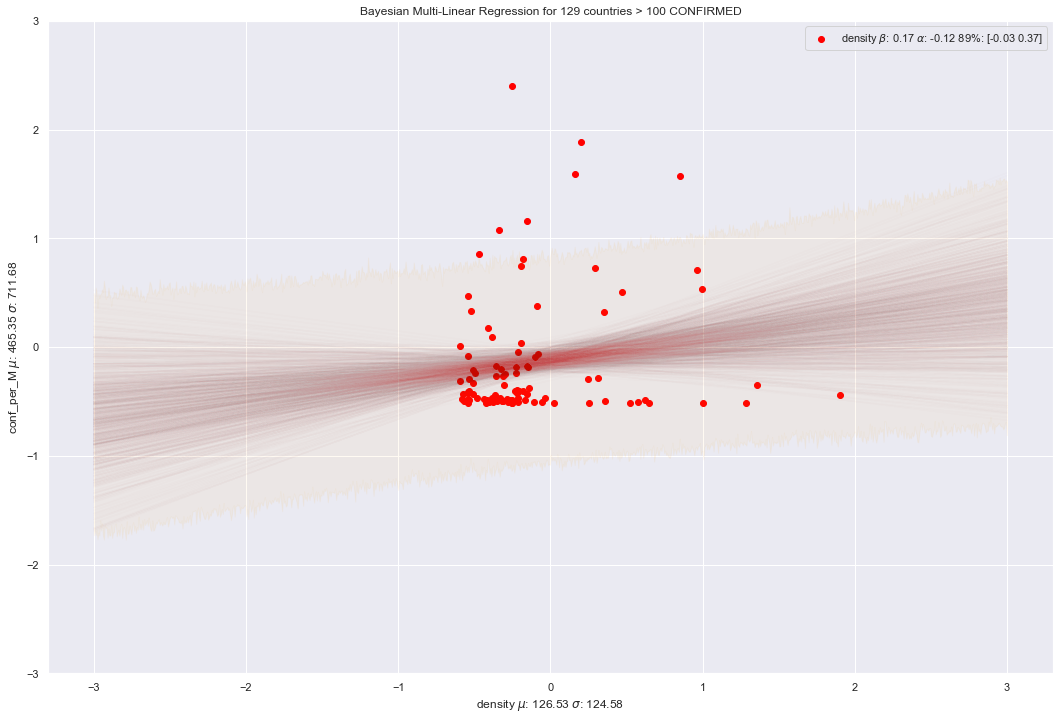

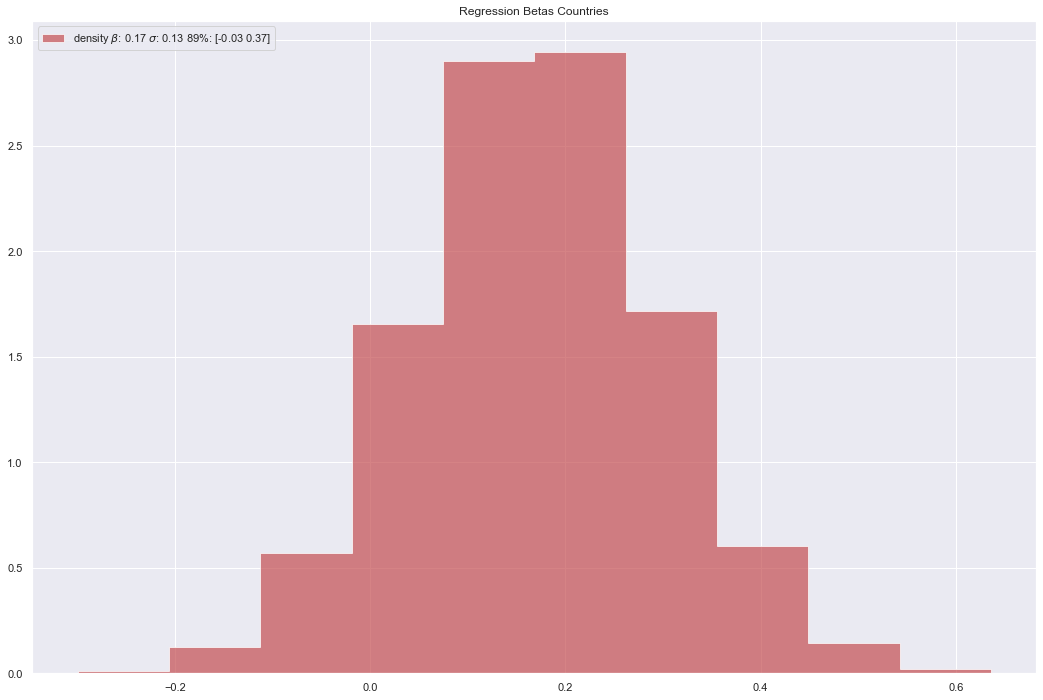

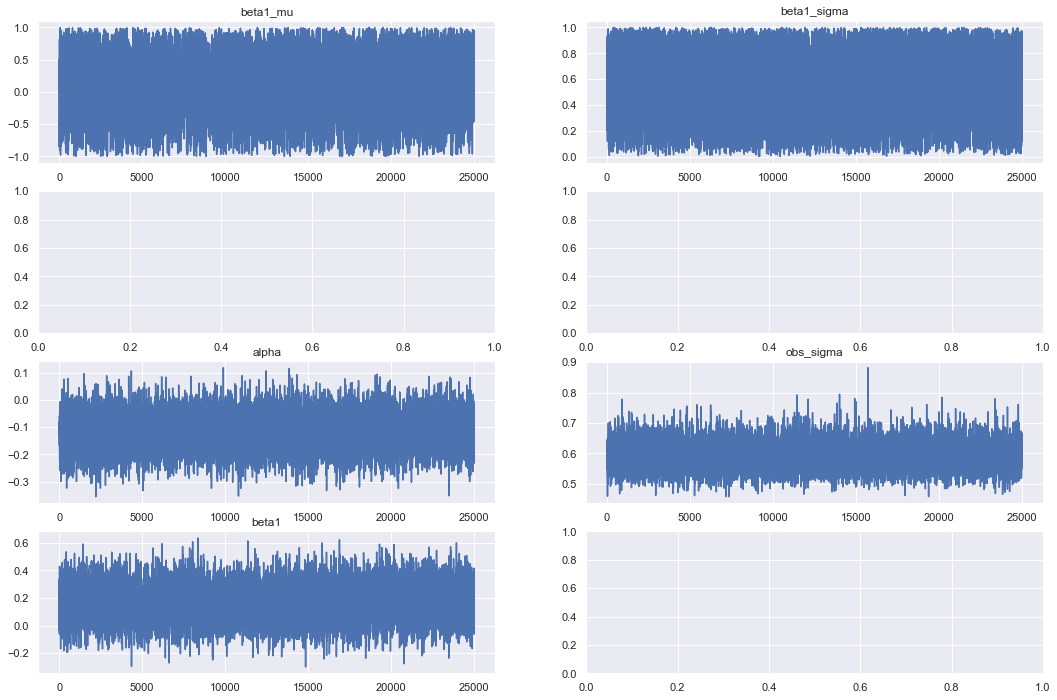

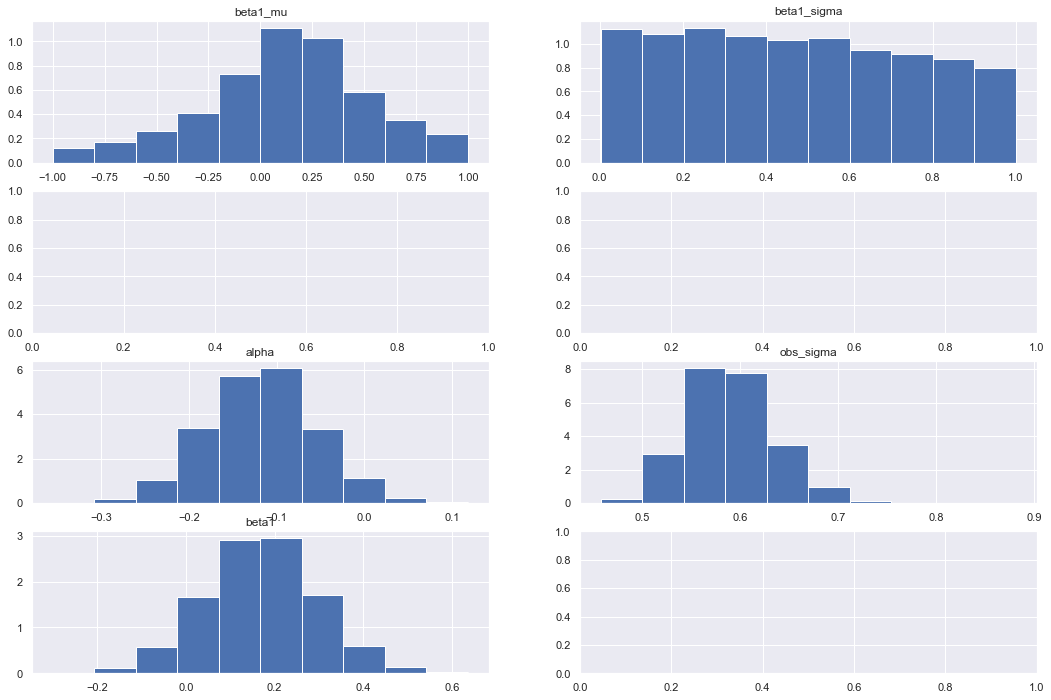

In [216]:
plot(result,x1,x2,y,'countries',nr_of_successful_countries)
plot_betas(result, 'Countries')
plot_traces(result,'World')
plot_posteriors(result,'World')

In [217]:
us_df = pd.read_pickle('US_states_latest_day.pkl')
us_df['gdp_per_capita'] = us_df['gdp'] 


x1 = us_df[x1_param]
x2 = us_df[x2_param]
y = us_df[y_param]

x1_mu = x1.mean()
print (x1_mu)
x1_sigma = x1.std()
x2_mu = x2.mean()
x2_sigma = x2.std()
y_mu = y.mean()
y_sigma = y.std()



1117.7365840592877


correlation:
[[1.         0.17232878]
 [0.17232878 1.        ]]
 [-----------------100%-----------------] 100000 of 100000 complete in 122.1 sec       beta1_mu_post  beta1_sigma_post  obs_sigma_post    alpha_post  \
count   25000.000000      25000.000000    25000.000000  25000.000000   
mean        0.559457          0.614224        0.464879      0.002990   
std         0.388797          0.265710        0.050337      0.097192   
min        -0.998776          0.002162        0.315388     -0.469943   
25%         0.360595          0.423662        0.430057     -0.062892   
50%         0.672711          0.653236        0.460623      0.002710   
75%         0.861037          0.840812        0.496528      0.069242   
max         0.999957          0.999996        0.746037      0.361393   

         beta1_post  
count  25000.000000  
mean       1.223959  
std        0.449606  
min       -0.770941  
25%        0.915818  
50%        1.207012  
75%        1.532457  
max        2.925610  
       be

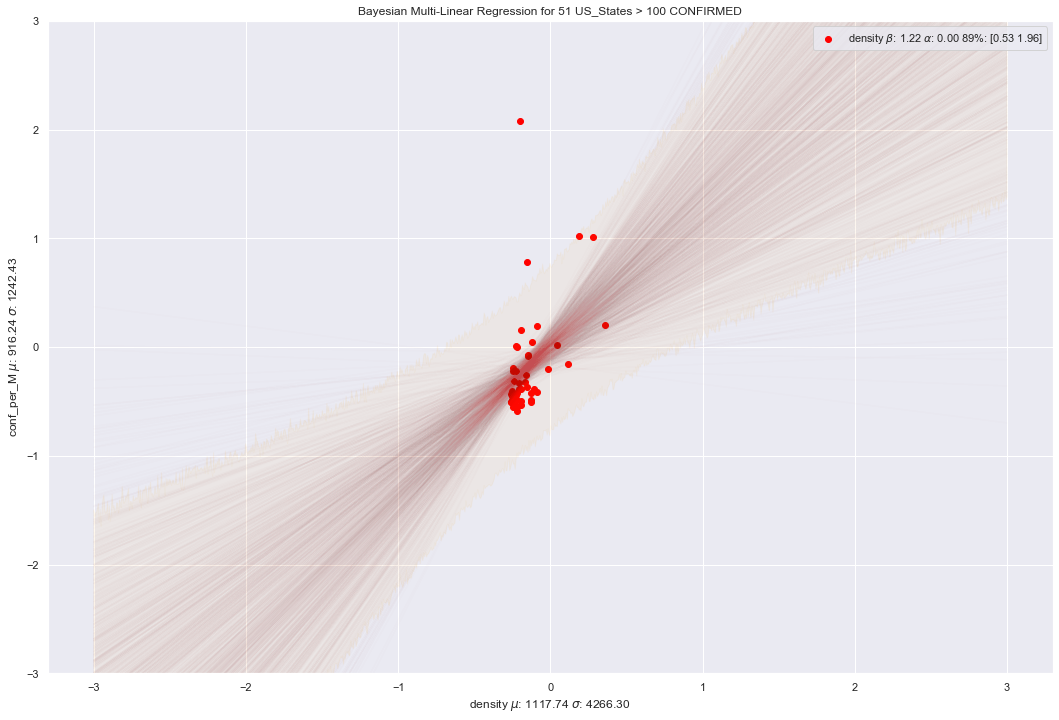

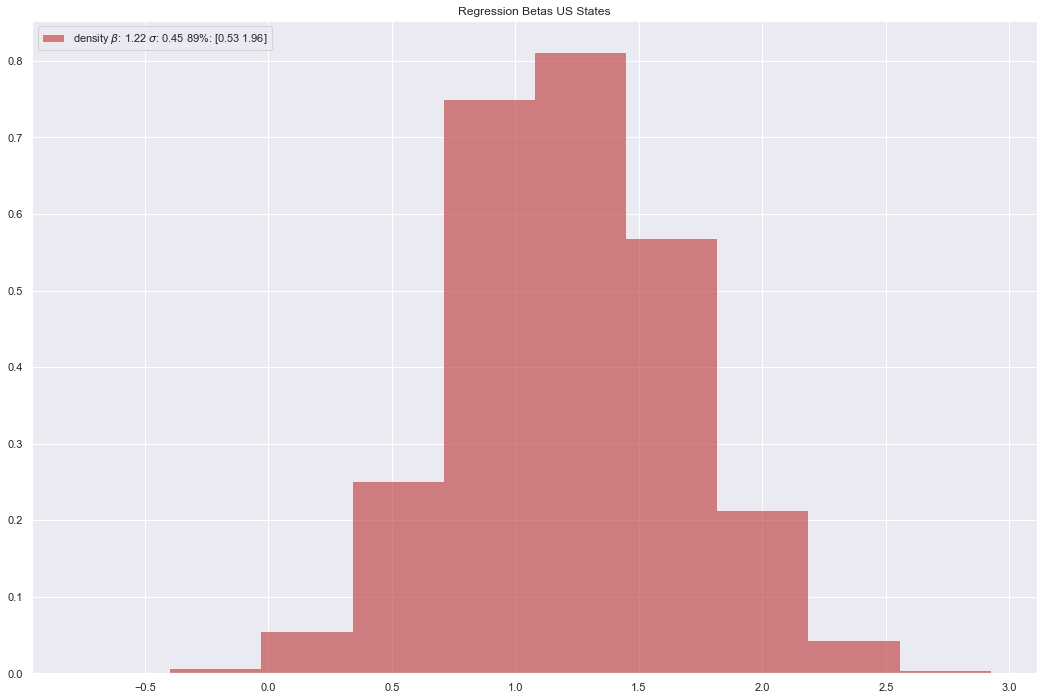

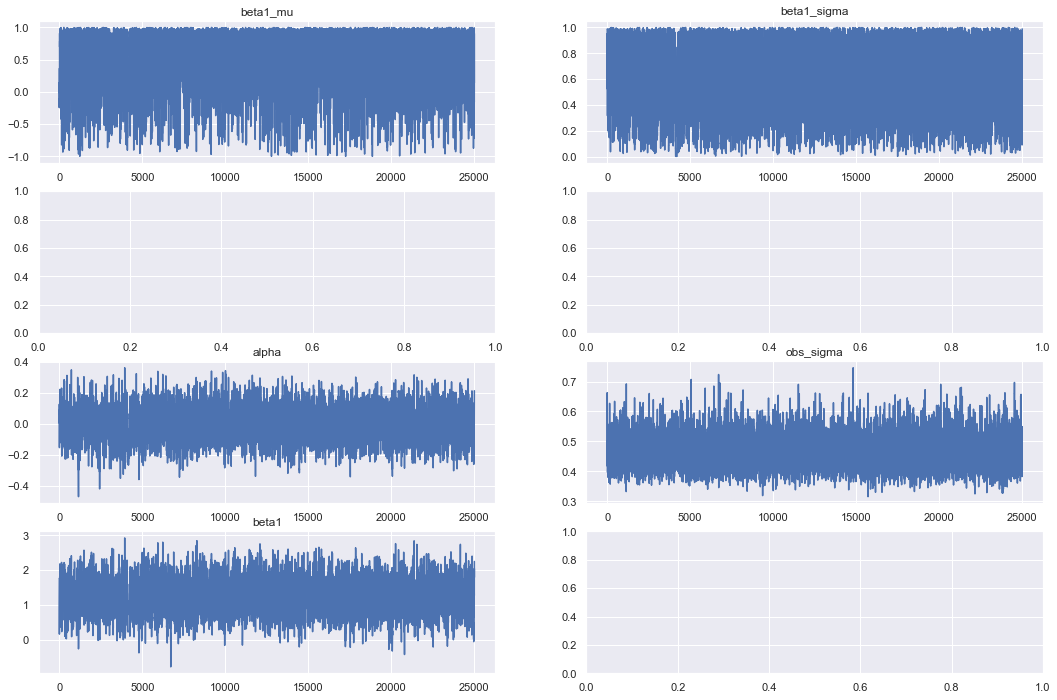

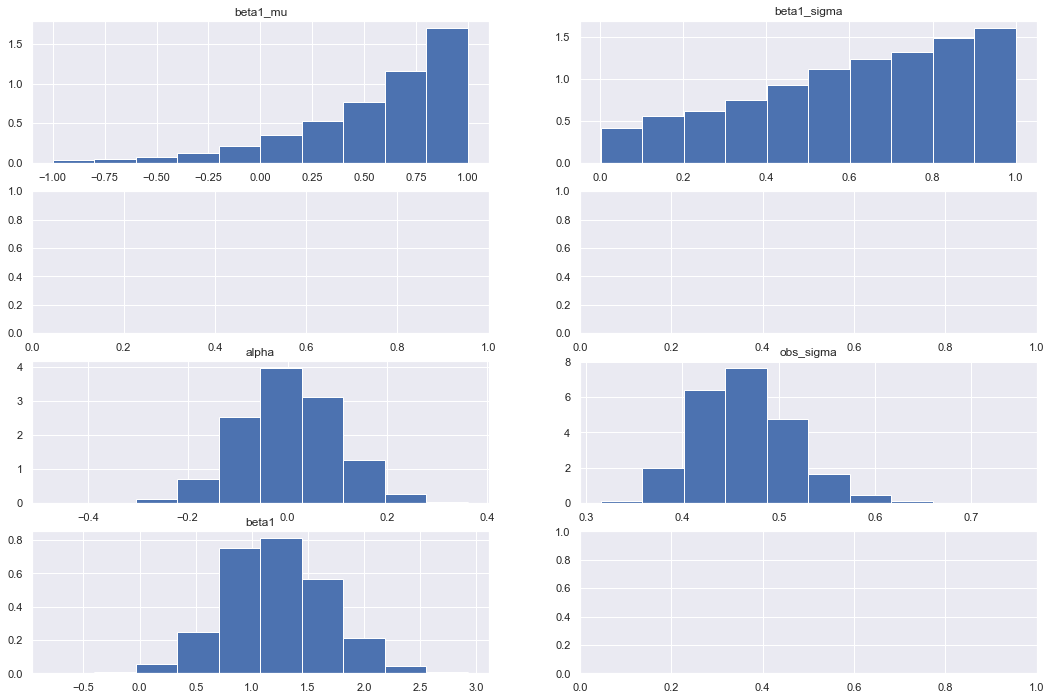

In [218]:

x1_std = standardize(x1)
x2_std = standardize(x2)
y_std = standardize(y)

print ('correlation:')
print (np.corrcoef(x1_std,y_std))

x1_outliers = (x1_std > outliers) | (x1_std < -1 * outliers) #std
x2_outliers = (x2_std > outliers) | (x1_std < -1 * outliers) #std
y_outliers = (y_std > outliers) | (x1_std < -1 * outliers) #std
    
outlier_idx = (x1_outliers | x2_outliers | y_outliers)
    
x1 = x1[~outlier_idx]
x1_std = x1_std[~outlier_idx]
x2 = x2[~outlier_idx]
x2_std = x2_std[~outlier_idx]
y = y[~outlier_idx]
y_std = y_std[~outlier_idx]
    
result = regression(x1_std,x2_std,y_std)
print (result.describe())
plot(result,x1_std,x2_std,y_std,'US_States',len(us_df))
plot_betas(result,'US States')
plot_traces(result,'US_States')
plot_posteriors(result,'US_States')
